In [1]:
# do the required imports
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# imports sklearn
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

from tqdm import tqdm, tqdm_notebook

In [2]:
filename = r'CElegans_384Well_A1-B24_GFP_TL_analyzed_TOC_CElegans_SingleObjects_Labels_cleaned.csv'

def check_separator(csvfile):

    reader = pd.read_csv(csvfile, sep=None, engine='python', iterator=True)
    sep = reader._engine.data.dialect.delimiter
    reader.close()

    return sep

def convert_dec_sep(df, np):

    for id in range(np, len(df.columns)):
        try:
            df.iloc[:, id] = df.iloc[:, id].str.replace(',', '.').astype('float')
        except:
            print('No correction of types possible for column: ', df.columns[id])
            
    return df

In [3]:
# check the used separator
sep = check_separator(filename)

# read the CSV table containing all the single object data
df_single = pd.read_csv(filename, sep=sep)

# get headers and number of measurement parameters
headers = df_single.head(0)

df_single[:3]

,Label GT,ID::ID!!I,ImageIndexScene::Image Index Scene!!I,ImageSceneContainerName::Image Scene Container Name,Area::Area!!R,BoundArea::Area Bound!!R,AreaConvex::Area Convex!!R,AreaF::Area Filled!!R,AreaP::Area Polygon!!R,Circularity::Circularity!!R,...,PerimeterF1::Perimeter Filled Unscaled!!R,PerimeterP::Perimeter Polygon!!R,PerimeterPF::Perimeter Polygon Filled!!R,PerimeterPF1::Perimeter Polygon Filled Unscaled!!R,PerimeterP1::Perimeter Polygon Unscaled!!R,Perimeter1::Perimeter Unscaled!!R,Radius::Radius!!R,Radius1::Radius Unscaled!!R,Roundness::Roundness!!R,ParentID::ID of the parent!!I
0,L,2,1,A1,25.68,63.84,47.407912,25.68,22.10,58555977,...,214.208153,42.275945,42.275945,211.379726,211.379726,214.208153,2.859055,14.295277,342880245,1
1,L,3,1,A1,34.72,176.64,83.651212,34.72,30.48,376773822,...,243.480231,48.130361,48.130361,240.651804,240.651804,243.480231,3.324413,16.622063,141958513,1
2,U,4,1,A1,78.92,384.00,205.671381,78.92,70.24,381191438,...,540.867099,107.607734,107.607734,538.038672,538.038672,540.867099,5.012087,25.060435,145306912,1


In [4]:
# rename table columns for better readability
cols={"ID::ID!!I":"ID",
      "ImageIndexScene::Image Index Scene!!I":"S",
      "ImageSceneContainerName::Image Scene Container Name ":"well"}

# rename colums
df_single.rename(columns=cols, inplace=True)

df_single[:3]

,Label GT,ID,S,well,Area::Area!!R,BoundArea::Area Bound!!R,AreaConvex::Area Convex!!R,AreaF::Area Filled!!R,AreaP::Area Polygon!!R,Circularity::Circularity!!R,...,PerimeterF1::Perimeter Filled Unscaled!!R,PerimeterP::Perimeter Polygon!!R,PerimeterPF::Perimeter Polygon Filled!!R,PerimeterPF1::Perimeter Polygon Filled Unscaled!!R,PerimeterP1::Perimeter Polygon Unscaled!!R,Perimeter1::Perimeter Unscaled!!R,Radius::Radius!!R,Radius1::Radius Unscaled!!R,Roundness::Roundness!!R,ParentID::ID of the parent!!I
0,L,2,1,A1,25.68,63.84,47.407912,25.68,22.10,58555977,...,214.208153,42.275945,42.275945,211.379726,211.379726,214.208153,2.859055,14.295277,342880245,1
1,L,3,1,A1,34.72,176.64,83.651212,34.72,30.48,376773822,...,243.480231,48.130361,48.130361,240.651804,240.651804,243.480231,3.324413,16.622063,141958513,1
2,U,4,1,A1,78.92,384.00,205.671381,78.92,70.24,381191438,...,540.867099,107.607734,107.607734,538.038672,538.038672,540.867099,5.012087,25.060435,145306912,1


In [5]:
# remove columns not needed for classification
df_class = df_single.drop(columns=['ID',
                                   'S',
                                   'well'], inplace=False)

# remove rows with units from dataframe
df_class.drop([0], inplace=True)


# convert decimal separators to point "."
df_class = convert_dec_sep(df_class, 0)

df_class[:3]

No correction of types possible for column:  Label GT
No correction of types possible for column:  Area::Area!!R
No correction of types possible for column:  BoundArea::Area Bound!!R
No correction of types possible for column:  AreaConvex::Area Convex!!R
No correction of types possible for column:  AreaF::Area Filled!!R
No correction of types possible for column:  AreaP::Area Polygon!!R
No correction of types possible for column:  Circularity::Circularity!!R
No correction of types possible for column:  Compactness::Compactness!!R
No correction of types possible for column:  Convexity::Convexity!!R
No correction of types possible for column:  Diameter::Diameter!!R
No correction of types possible for column:  FeretRatio::Feret Ratio!!R
No correction of types possible for column:  BoundArea1::Area Bound Unscaled!!R
No correction of types possible for column:  AreaF1::Area Filled Unscaled!!R
No correction of types possible for column:  AreaP1::Area Polygon Unscaled!!R
No correction of type

,Label GT,Area::Area!!R,BoundArea::Area Bound!!R,AreaConvex::Area Convex!!R,AreaF::Area Filled!!R,AreaP::Area Polygon!!R,Circularity::Circularity!!R,Compactness::Compactness!!R,Convexity::Convexity!!R,Diameter::Diameter!!R,...,PerimeterF1::Perimeter Filled Unscaled!!R,PerimeterP::Perimeter Polygon!!R,PerimeterPF::Perimeter Polygon Filled!!R,PerimeterPF1::Perimeter Polygon Filled Unscaled!!R,PerimeterP1::Perimeter Polygon Unscaled!!R,Perimeter1::Perimeter Unscaled!!R,Radius::Radius!!R,Radius1::Radius Unscaled!!R,Roundness::Roundness!!R,ParentID::ID of the parent!!I
1,L,34.72,176.64,83.651212,34.72,30.48,376773822,259702098,788234754,6.648825,...,243.480231,48.130361,48.130361,240.651804,240.651804,243.480231,3.324413,16.622063,141958513,1
2,U,78.92,384.00,205.671381,78.92,70.24,381191438,244158857,386199934,10.024174,...,540.867099,107.607734,107.607734,538.038672,538.038672,540.867099,5.012087,25.060435,145306912,1
3,L,40.00,202.52,108.040200,40.00,35.36,378240152,252871356,753191508,7.136496,...,270.936075,53.621530,53.621530,268.107648,268.107648,270.936075,3.568248,17.841241,143065613,1


In [6]:
# define label array from labels
label = np.zeros((df_class.shape[0],), dtype=np.integer)

index = -1
for t in df_class['Label GT']:
    index += 1
    if t == 'D':
        label[index] = 0
    if t == 'L':
        label[index] = 1
    if t == 'U':
        label[index] = 2

# define class names
class_names = ['dead', 'live', 'undefined']

In [7]:
# remove type column
df_train = df_class.drop(columns=['Label GT'], inplace = False)

# get feature names
feature_list = list(df_train.columns)

# show dataset
print(df_train.shape)
df_train[:3]

(599, 77)


,Area::Area!!R,BoundArea::Area Bound!!R,AreaConvex::Area Convex!!R,AreaF::Area Filled!!R,AreaP::Area Polygon!!R,Circularity::Circularity!!R,Compactness::Compactness!!R,Convexity::Convexity!!R,Diameter::Diameter!!R,FeretRatio::Feret Ratio!!R,...,PerimeterF1::Perimeter Filled Unscaled!!R,PerimeterP::Perimeter Polygon!!R,PerimeterPF::Perimeter Polygon Filled!!R,PerimeterPF1::Perimeter Polygon Filled Unscaled!!R,PerimeterP1::Perimeter Polygon Unscaled!!R,Perimeter1::Perimeter Unscaled!!R,Radius::Radius!!R,Radius1::Radius Unscaled!!R,Roundness::Roundness!!R,ParentID::ID of the parent!!I
1,34.72,176.64,83.651212,34.72,30.48,376773822,259702098,788234754,6.648825,410361141,...,243.480231,48.130361,48.130361,240.651804,240.651804,243.480231,3.324413,16.622063,141958513,1
2,78.92,384.00,205.671381,78.92,70.24,381191438,244158857,386199934,10.024174,477752797,...,540.867099,107.607734,107.607734,538.038672,538.038672,540.867099,5.012087,25.060435,145306912,1
3,40.00,202.52,108.040200,40.00,35.36,378240152,252871356,753191508,7.136496,408315442,...,270.936075,53.621530,53.621530,268.107648,268.107648,270.936075,3.568248,17.841241,143065613,1


In [8]:
extra_clean = False

if extra_clean:
    # optiional data cleaning
    df_train.drop(df_train[df_train.feretmax < 15.29].index, inplace=True)
    print(df_train.shape)
    df_train[:3]

In [9]:
# get data as numpy array from dataframe
data = df_train.values
print(type(data), data.shape)

<class 'numpy.ndarray'> (599, 77)


In [10]:
# split data for training
data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.5, random_state=0)

In [11]:
# scale data
scale = True

if scale:
    # Feature Scaling
    sc = StandardScaler()
    data_train = sc.fit_transform(data_train)
    data_test = sc.transform(data_test) 

In [12]:
# iniate classifier
classifier = RandomForestClassifier(n_estimators=10,
                                    bootstrap=True,
                                    random_state=20,
                                    verbose=0)

# build a forest of trees from the training set (data, label)
classifier.fit(data_train, label_train)

# predict class for data
label_pred = classifier.predict(data_test)

# show results
confm_notnormed = confusion_matrix(label_test, label_pred)
confm_normed = np.round(confm_notnormed.astype('float') / confm_notnormed.sum(axis=1)[:, np.newaxis], 2)
class_report = classification_report(label_test, label_pred)
acc_score = accuracy_score(label_test, label_pred)
fi = classifier.feature_importances_

print(confm_notnormed)
print('------------------------------------')
print(confm_normed)
print('------------------------------------')
print(class_report)
print('------------------------------------')
print('Accuray Score : ', acc_score)

[[147   3   4]
 [  5  57   1]
 [  8   7  68]]
------------------------------------
[[0.95 0.02 0.03]
 [0.08 0.9  0.02]
 [0.1  0.08 0.82]]
------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       154
           1       0.85      0.90      0.88        63
           2       0.93      0.82      0.87        83

    accuracy                           0.91       300
   macro avg       0.90      0.89      0.90       300
weighted avg       0.91      0.91      0.91       300

------------------------------------
Accuray Score :  0.9066666666666666


In [13]:
feature_imp = {'Features': feature_list, 'Importance': fi}
fimp = pd.DataFrame(data=feature_imp)

# show feature importance
fimp

,Features,Importance
0,Area::Area!!R,0.015410
1,BoundArea::Area Bound!!R,0.003730
2,AreaConvex::Area Convex!!R,0.050422
3,AreaF::Area Filled!!R,0.001100
4,AreaP::Area Polygon!!R,0.000000
...,...,...
72,Perimeter1::Perimeter Unscaled!!R,0.024397
73,Radius::Radius!!R,0.003230
74,Radius1::Radius Unscaled!!R,0.006287
75,Roundness::Roundness!!R,0.003535


In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    fontsize=16,
                    color="red" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(im, cax=cax)
    
    return ax

Confusion matrix, without normalization
Normalized confusion matrix


<AxesSubplot:title={'center':'Confusion matrix normalized'}, xlabel='Predicted label', ylabel='True label'>

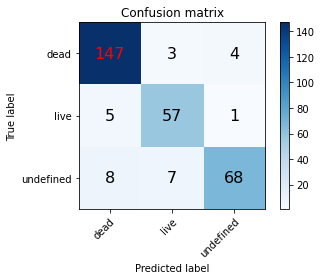

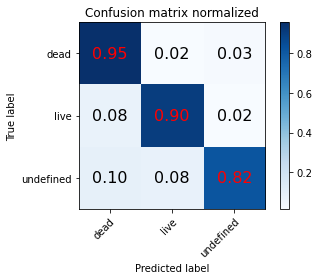

In [15]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(label_test, label_pred, classes=np.asarray(class_names), normalize=False,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(label_test, label_pred, classes=np.asarray(class_names), normalize=True,
                      title='Confusion matrix normalized')



In [25]:
rs_max = 20
estimator_max = 20

rs_estimator_matrix = np.zeros((rs_max, estimator_max-1), dtype=np.float)

for n in tqdm_notebook(range(1, estimator_max, 1)):
    for rstate in range(0, rs_max, 1):

        # iniate classifier
        classifier = RandomForestClassifier(n_estimators=n,
                                            bootstrap=True,
                                            random_state=rstate,
                                            verbose=0)
       
        # build a forest of trees from the training set (data, label)
        classifier.fit(data_train, label_train)
        
        # predict class for data
        label_pred = classifier.predict(data_test)
        
        # show results
        rs_estimator_matrix[rstate, n-1] = accuracy_score(label_test, label_pred)

C:\ProgramData\Anaconda3\envs\stardist\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(rs_estimator_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_xlabel('n_estimators')
ax.set_ylabel('random_state')
ax.set_title('Accuray')
fig.tight_layout()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)